In [426]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
from scipy.optimize import curve_fit
from ast import literal_eval


import sys
#sys.path.append('/home/zelie/Python_projects/\
#water_scarcity_model/LowFlow/Code') 

from climada.hazard.low_flow import LowFlow

from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import datetime


In [427]:
def init_IFS_linear(s):
    """define impact function imp_fun and return impact function set (IFS)"""
    x0 = np.linspace(0,365,100)
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'LF'
    imp_fun.id = 1
    imp_fun.name = 'Low flow business interruption'
    imp_fun.intensity_unit = 'days'
    imp_fun.intensity = x0
    imp_fun.mdd = s*x0
    imp_fun.mdd[imp_fun.mdd>1]=1
 # loss to annual operation
    imp_fun.paa = imp_fun.intensity * 0 + 1
    #imp_fun.paa[imp_fun.intensity<mdm] = 0
    imp_fun.check()
    IFS = ImpactFuncSet()
    IFS.append(imp_fun)
    return IFS


# New Attempt, using historical events

### to do: 
###            1. load hazards for the years& regions found in the literature research
###            2. calculate impacts until equivalent loss of production is found
###            3. compare to 'normal' years


In [428]:
wri_power_plants_path = '/home/zelie/Python_projects/low_flow/data/exposure/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

In [429]:
hydro = load_exposure(primary_fuel='Hydro')

2020-06-26 15:40:43,405 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-26 15:40:43,607 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-26 15:40:43,608 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-26 15:40:43,608 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-26 15:40:43,608 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 15:40:43,609 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 15:40:43,609 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-26 15:40:43,609 - climada.entity.exposures.base - INFO - cover not set.
2020-06-26 15:40:43,610 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 15:40:43,610 - climada.entity.exposures.base - INFO - region_id not set.


# Spain 2005 Drought

In Spain, the 2005 drought led to a reduction of 36% in national hydroelectric power
production (equivalent to 12 876 GWh), with respect to the past five year average. The
decrease in hydraulic and nuclear production has been compensated by an increase in fuel-gas
plant production and combined cycles that increased their production by respectively 28% and
66%, compared to 2004. This extra production led to an additional cost of 713 Mio €. It is
also worthwhile to mention that replacing hydro-electricity by fossil fuel gave rise to
environmental impacts. 
source: https://ec.europa.eu/environment/water/quantity/pdf/comm_droughts/2nd_int_report.pdf p.45

In [430]:

min_days_per_month = 5
percentile = 2.5
input_dir = '../data/isimip_data/'
gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange=[2005,2006]
yearrange_ref=[1981,2005]
bbox = [-9,34,9,45]
spain_2005 = LowFlow()
min_intensity = 5
min_number_cells = 16

spain_2005.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)


GETTING STARTED!
2020-06-26 15:40:53,118 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-06-26 15:41:08,246 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-06-26 15:41:09,334 - climada.hazard.low_flow - INFO - Filtering events: 1 events remaining


In [ ]:
yearrange=[2000,2005]

spain_2000_2005 = LowFlow()
spain_2000_2005.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)


In [431]:
hydro_spain = hydro[hydro['country']=='ESP']
hydro_spain = Exposures(hydro_spain)
hydro_spain.check()

2020-06-26 15:41:09,344 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-26 15:41:09,344 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 15:41:09,345 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 15:41:09,345 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-26 15:41:09,345 - climada.entity.exposures.base - INFO - cover not set.
2020-06-26 15:41:09,346 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 15:41:09,346 - climada.entity.exposures.base - INFO - region_id not set.


In [97]:
hydro_spain.value.sum()*0.36 ( a bit overestimated, might have changes since 2005)

15469.199999999999

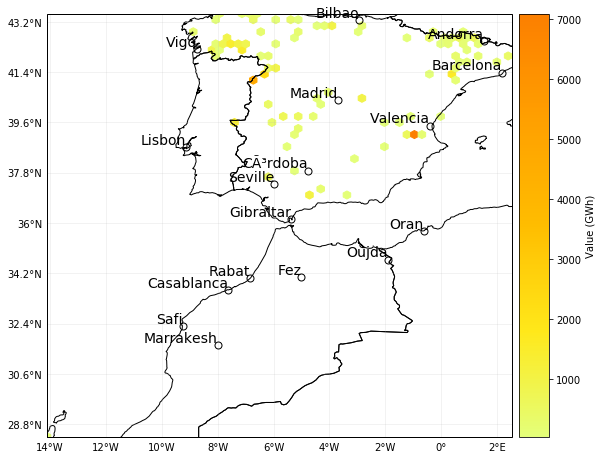

In [96]:
hydro_spain.plot_hexbin()

In [432]:
IFS_lf = init_IFS_linear(0.007)

2020-06-26 15:41:09,351 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [433]:
imp_spain_2005 = Impact()
imp_spain_2005.calc(hydro_spain, IFS_lf, spain_2005)
print(imp_spain_2005.at_event.sum()/(imp_spain_2005.tot_value)*100)


2020-06-26 15:41:09,356 - climada.entity.exposures.base - INFO - Matching 124 exposures with 792 centroids.
2020-06-26 15:41:09,361 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 1 events.
0.0


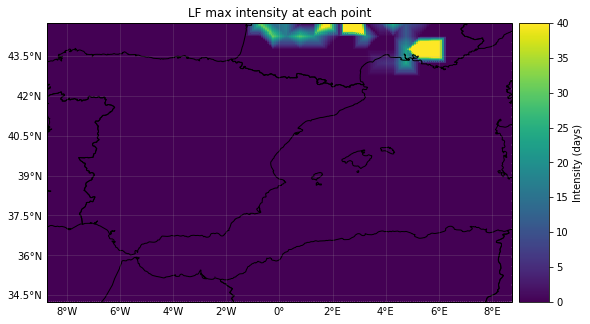

In [435]:
spain_2005.plot_intensity(0,vmax=40)

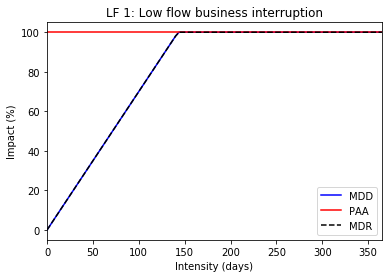

In [98]:
IFS_lf.plot()

In [126]:
imp_spain_2000_2005 = Impact()
imp_spain_2000_2005.calc(hydro_spain, IFS_lf, spain_2000_2005)
print(imp_spain_2000_2005.at_event.sum()/(imp_spain_2000_2005.tot_value*5)*100)


2020-06-25 18:20:56,701 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-25 18:20:56,703 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 8 events.
5.865461807416981


In [438]:
nuclear = load_exposure(primary_fuel='Nuclear')
nuclear_germany = nuclear[nuclear['country_long']=='Germany']
nuclear_germany = Exposures(nuclear_germany)
nuclear_germany.check()

2020-06-26 15:44:42,372 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-26 15:44:42,381 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-26 15:44:42,381 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-26 15:44:42,382 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-26 15:44:42,382 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 15:44:42,382 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 15:44:42,383 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-26 15:44:42,383 - climada.entity.exposures.base - INFO - cover not set.
2020-06-26 15:44:42,383 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 15:44:42,384 - climada.entity.exposures.base - INFO - region_id not set.
2020-06-26 15:44:42,386 - cl

In [437]:
nuclear_germany.plot_scatter(cmap='spring')

NameError: name 'nuclear_germany' is not defined

In [436]:
min_days_per_month = 5
percentile = 2.5
input_dir = '../data/isimip_data/'
gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange=[2003,2004]
yearrange_ref=[1981,2005]
bbox = [5,40,15,55]
germany_2003 = LowFlow()
min_intensity=5
min_number_cells=16

germany_2003.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)


GETTING STARTED!
2020-06-26 15:44:14,274 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-06-26 15:44:29,741 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-06-26 15:44:31,278 - climada.hazard.low_flow - INFO - Filtering events: 3 events remaining


/home/zelie/Python_projects/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


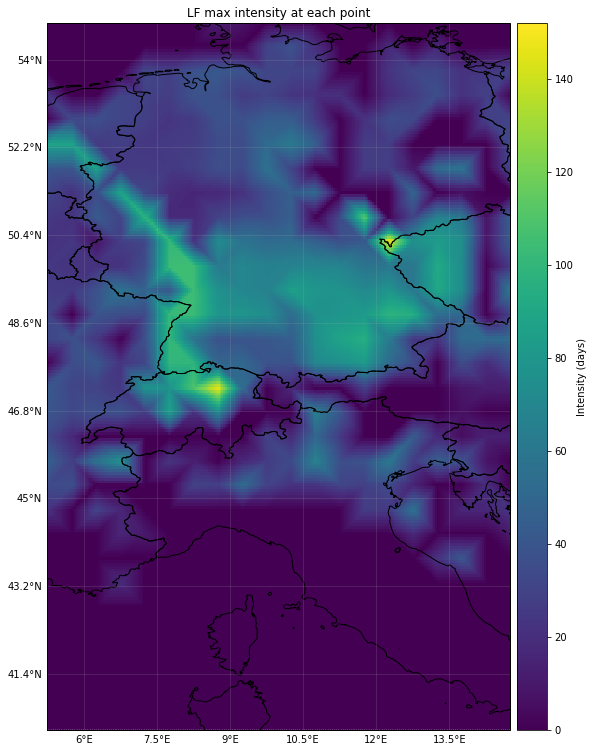

In [37]:
germany_2003.plot_intensity(0)

In [439]:
IFS_lf = init_IFS_linear(0.00173)

imp_germany_2003 = Impact()
imp_germany_2003.calc(nuclear_germany, IFS_lf, germany_2003)
print(imp_germany_2003.at_event.sum()/imp_germany_2003.tot_value*100)


2020-06-26 15:44:44,923 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 15:44:44,924 - climada.entity.exposures.base - INFO - Matching 7 exposures with 600 centroids.
2020-06-26 15:44:44,927 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 3 events.
11.029867886503608


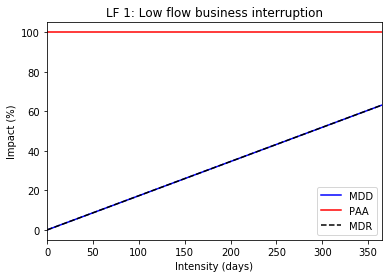

In [440]:
IFS_lf.plot()

In [116]:
yearrange=[2000,2005]

germany_2000_2005 = LowFlow()
germany_2000_2005
germany_2000_2005.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)


GETTING STARTED!
2020-06-25 18:18:06,320 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005


/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:546: RuntimeWarning: invalid value encountered in less
  data.dis.values[data.dis.values < 0] = 0
/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:546: RuntimeWarning: invalid value encountered in less
  data.dis.values[data.dis.values < 0] = 0
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020-06-25 18:18:21,813 - climada.hazard.centroids.centr - INFO - Setting geometry points.


/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:614: RuntimeWarning: invalid value encountered in greater_equal
  data_threshold.dis.values[data_threshold.dis.values >= 0] = 0
/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:615: RuntimeWarning: invalid value encountered in less
  data_threshold.dis.values[data_threshold.dis.values < 0] = 1
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/co

/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Serie

/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Serie

2020-06-25 18:18:25,159 - climada.hazard.low_flow - INFO - Filtering events: 6 events remaining


In [125]:
imp_germany_2000_2005 = Impact()
imp_germany_2000_2005.calc(nuclear_germany, IFS_lf, germany_2000_2005)
print(imp_germany_2000_2005.at_event.sum()/(imp_germany_2000_2005.tot_value*5)*100)


2020-06-25 18:20:14,834 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-25 18:20:14,836 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 6 events.
0.2656556598138626


# France 2003 & 2006

## Les pertes de production ont atteint 5,5 TWh en 2003 et 2,5 TWh en 2006
https://www.sfen.org/rgn/adapter-centrales-nucleaires-changement-climatique

In [238]:
min_days_per_month = 5
percentile = 2.5
input_dir = '../data/isimip_data/'
gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange=[2003,2004]
yearrange_ref=[1981,2005]
bbox = [-5,40,10,55]
min_intensity=5
min_number_cells=16

france_2003 = LowFlow()

france_2003.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)

yearrange=[2006,2007]

france_2006 = LowFlow()

france_2006.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)


GETTING STARTED!
2020-06-26 14:05:36,695 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-06-26 14:05:53,082 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-06-26 14:05:54,891 - climada.hazard.low_flow - INFO - Filtering events: 3 events remaining
GETTING STARTED!
2020-06-26 14:05:56,109 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-06-26 14:06:11,642 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-06-26 14:06:13,452 - climada.hazard.low_flow - INFO - Filtering events: 3 events remaining


/home/zelie/Python_projects/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


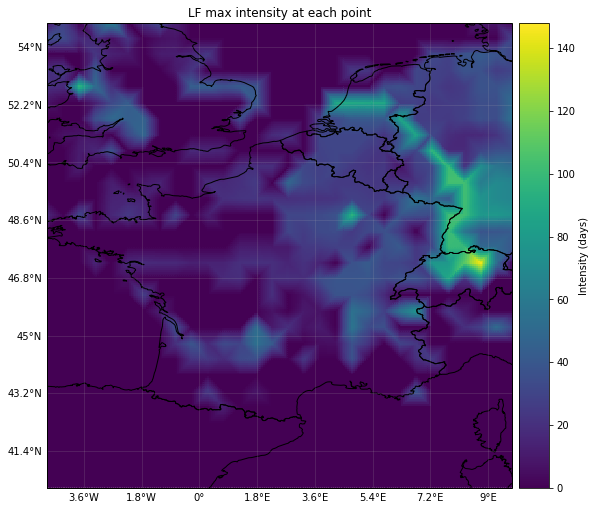

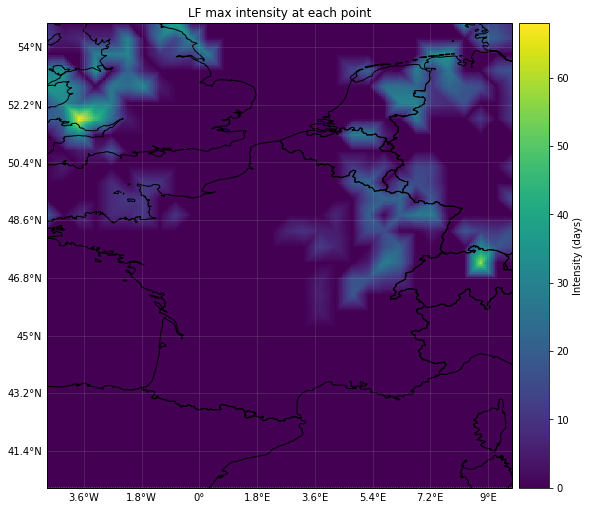

In [128]:
france_2003.plot_intensity(0)
france_2006.plot_intensity(0)

In [129]:
nuclear_france= nuclear[nuclear['country_long']=='France']
nuclear_france = Exposures(nuclear_france)
nuclear_france.check()

2020-06-25 18:21:54,205 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-25 18:21:54,208 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-25 18:21:54,209 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-25 18:21:54,209 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-25 18:21:54,210 - climada.entity.exposures.base - INFO - cover not set.
2020-06-25 18:21:54,210 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-25 18:21:54,211 - climada.entity.exposures.base - INFO - region_id not set.


In [138]:
IFS_lf_t2 = init_IFS_linear(0.00044)

imp_france_2003 = Impact()
imp_france_2003.calc(nuclear_france, IFS_lf_t2, france_2003)
print(imp_france_2003.at_event.sum()/1000)

IFS_lf_t3 = init_IFS_linear(0.002)


imp_france_2006 = Impact()
imp_france_2006.calc(nuclear_france, IFS_lf_t3, france_2006)
print(imp_france_2006.at_event.sum()/1000)

2020-06-25 18:23:22,434 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-25 18:23:22,435 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-25 18:23:22,436 - climada.engine.impact - INFO - Calculating damage for 19 assets (>0) and 3 events.
5.583736589716457
2020-06-25 18:23:22,438 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-25 18:23:22,439 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-25 18:23:22,440 - climada.engine.impact - INFO - Calculating damage for 19 assets (>0) and 3 events.
2.514720786947569


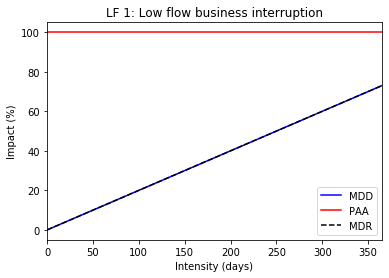

In [141]:
IFS_lf_t3.plot()

## --> should be 5.5 amd 2.5TWh is 7, 0.7Twh

# Europe 2003

In [143]:
min_days_per_month = 5
percentile = 2.5
input_dir = '../data/isimip_data/'
gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange=[2003,2004]
yearrange_ref=[1981,2005]
bbox = [-8,38,60,60]
min_intensity=5
min_number_cells=16

eu_2003 = LowFlow()

eu_2003.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                        min_intensity=min_intensity, min_number_cells=min_number_cells)

GETTING STARTED!
2020-06-25 18:28:34,762 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005


/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:546: RuntimeWarning: invalid value encountered in less
  data.dis.values[data.dis.values < 0] = 0
/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:546: RuntimeWarning: invalid value encountered in less
  data.dis.values[data.dis.values < 0] = 0
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


2020-06-25 18:28:55,433 - climada.hazard.centroids.centr - INFO - Setting geometry points.


/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:614: RuntimeWarning: invalid value encountered in greater_equal
  data_threshold.dis.values[data_threshold.dis.values >= 0] = 0
/home/zelie/Python_projects/climada_python/climada/hazard/low_flow.py:615: RuntimeWarning: invalid value encountered in less
  data_threshold.dis.values[data_threshold.dis.values < 0] = 1
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in 

/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Serie

/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Serie

/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Serie

/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
/home/zelie/miniconda3/envs/climada_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Serie

2020-06-25 18:29:03,810 - climada.hazard.low_flow - INFO - Filtering events: 13 events remaining


In [158]:
nuclear_eu = load_exposure(bbox=bbox, primary_fuel='Nuclear')

2020-06-25 18:34:09,777 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-25 18:34:09,781 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-25 18:34:09,782 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-25 18:34:09,782 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-25 18:34:09,783 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-25 18:34:09,783 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-25 18:34:09,783 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-25 18:34:09,784 - climada.entity.exposures.base - INFO - cover not set.
2020-06-25 18:34:09,784 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-25 18:34:09,784 - climada.entity.exposures.base - INFO - region_id not set.


In [165]:
IFS_lf_t4 = init_IFS_linear(0.0022)

imp_eu_2003 = Impact()
imp_eu_2003.calc(nuclear_eu, IFS_lf_t4, eu_2003)
print(imp_eu_2003.at_event.sum()/(imp_eu_2003.tot_value)*100)

2020-06-25 18:34:41,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-25 18:34:41,853 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-25 18:34:41,858 - climada.engine.impact - INFO - Calculating damage for 67 assets (>0) and 13 events.
4.86361818693669


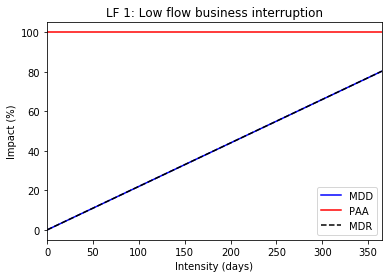

In [166]:
IFS_lf_t4.plot()

In [172]:
hydro_eu = load_exposure(bbox=bbox, primary_fuel='Hydro')
IFS_lh_t2 = init_IFS_linear(0.0055)

imp_eu_2003 = Impact()
imp_eu_2003.calc(hydro_eu, IFS_lf_t4, eu_2003)
print(imp_eu_2003.at_event.sum()/(imp_eu_2003.tot_value)*100)

2020-06-25 18:37:19,249 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-25 18:37:19,305 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-25 18:37:19,306 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-25 18:37:19,306 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-25 18:37:19,307 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-25 18:37:19,308 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-25 18:37:19,308 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-25 18:37:19,308 - climada.entity.exposures.base - INFO - cover not set.
2020-06-25 18:37:19,309 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-25 18:37:19,309 - climada.entity.exposures.base - INFO - region_id not set.
2020-06-25 18:37:19,315 - cl

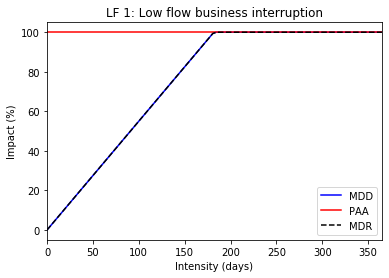

In [173]:
IFS_lh_t2.plot()

In [708]:
import warnings
warnings.filterwarnings("ignore")
input_dir = '../data/isimip_data/'
year0 = np.min(historical_data['date0']).year
yearn = np.max(historical_data['daten']).year
yearrange=[year0,yearn]


min_days_per_month = 5
percentile = 2.5
gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange_ref=[1981,2005]
bbox = [-15,30,50,72]
min_intensity=5
min_number_cells=16

hazard = LowFlow()
hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                        cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                            min_intensity=min_intensity, min_number_cells=min_number_cells)



GETTING STARTED!
2020-06-26 17:25:03,782 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-06-26 17:25:25,267 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-06-26 17:26:42,385 - climada.hazard.low_flow - INFO - Filtering events: 162 events remaining


In [709]:
def init_IFS_linear(s):
    """define impact function imp_fun and return impact function set (IFS)"""
    x0 = np.linspace(0,365,100)
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'LF'
    imp_fun.id = 1
    imp_fun.name = 'Low flow business interruption'
    imp_fun.intensity_unit = 'days'
    imp_fun.intensity = x0
    imp_fun.mdd = s*x0
    imp_fun.mdd[imp_fun.mdd>1]=1
 # loss to annual operation
    imp_fun.paa = imp_fun.intensity * 0 + 1
    #imp_fun.paa[imp_fun.intensity<mdm] = 0
    imp_fun.check()
    IFS = ImpactFuncSet()
    IFS.append(imp_fun)
    return IFS

wri_power_plants_path = '/home/zelie/Python_projects/low_flow/data/exposure/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

def if_finder(historical_data, hazard, input_dir=None, centroids=None,
                    bbox=None, percentile=2.5, min_intensity=5, min_number_cells=16,
                    min_days_per_month=5, yearrange_ref=[1981,2010],
                    gh_model='h08', cl_model='gswp3',
                    scenario='hist', scenario_ref='hist', soc='pressoc', \
                    fn_str_var='co2_dis_global_daily', bias_correction = 'nobc'):
    
    
    
    energies = historical_data['Energy'].unique()
    exposures = {}
    for e in energies:
        exposures[e] = load_exposure(primary_fuel=e)
    
    
    for index, row in historical_data.iterrows():
        year0 = historical_data['date0'][index].year
        yearn = historical_data['daten'][index].year
        yearrange = [year0,yearn]
        exposuresn = exposures[historical_data['Energy'][index]]
        country = historical_data['Country'][index].split(',')
        exposuresn = exposuresn[exposuresn.country_long.isin(country)]
        exposuresn = Exposures(exposuresn)
        exposuresn.check()
        hazardn = hazard.select(date=(historical_data['date0'][index].toordinal(),historical_data['daten'][index].toordinal()))
        slope=0.001
        impacts_sum = 0
        print(historical_data['loss'][index])
        while historical_data['loss'][index]>impacts_sum:
            print(impacts_sum)
            slope = slope + 0.0001
            if slope > 0.01:
                slope = 'NA'
                break
            impact_function = init_IFS_linear(slope)
            impact = Impact()
            impact.calc(exposuresn, impact_function, hazardn)
            if historical_data['unit'][index]=='percentage':
                impacts_sum = impact.at_event.sum()/(impact.tot_value*(yearn-year0))*100
            else:
                impacts_sum = impact.at_event.sum()
        historical_data['slope_if'][index] = slope
    return(historical_data)
   

In [710]:
historical_data = pd.read_excel('historical_impacts.xlsx')

historical_data = if_finder(historical_data.loc[0:12], hazard, input_dir=input_dir, bbox=bbox)

2020-06-26 17:26:49,096 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-26 17:26:49,297 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-26 17:26:49,297 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-26 17:26:49,297 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-26 17:26:49,298 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 17:26:49,298 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 17:26:49,298 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-26 17:26:49,300 - climada.entity.exposures.base - INFO - cover not set.
2020-06-26 17:26:49,300 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 17:26:49,300 - climada.entity.exposures.base - INFO - region_id not set.
2020-06-26 17:26:49,428 - cl

2020-06-26 17:26:49,526 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,530 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,532 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,536 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,536 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,537 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0

2020-06-26 17:26:49,622 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,624 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,628 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,629 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,630 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,633 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,633 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:49,710 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,712 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,714 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,715 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,716 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,718 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,719 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:49,801 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,802 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,804 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,805 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,806 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,809 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,810 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:49,890 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,891 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,895 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,896 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,898 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,903 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-26 17:26:49,903 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 17:26:49,903 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 17:26:49,904 - climada.e

2020-06-26 17:26:49,979 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,982 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,983 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,984 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:49,986 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:49,986 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:49,987 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0

2020-06-26 17:26:50,060 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,061 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:50,064 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,065 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,066 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:50,068 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,069 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:50,146 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,147 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:50,150 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,150 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,151 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:50,153 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,153 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:50,242 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,243 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:50,246 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,247 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,248 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-06-26 17:26:50,251 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,252 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:50,323 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 17:26:50,323 - climada.entity.exposures.base - INFO - region_id not set.
10000.0
0
2020-06-26 17:26:50,327 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,328 - climada.entity.exposures.base - INFO - Matching 429 exposures with 10920 centroids.
2020-06-26 17:26:50,330 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
1510.1119656973974
2020-06-26 17:26:50,333 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,334 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,335 - cl

2020-06-26 17:26:50,403 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
3843.921367229737
2020-06-26 17:26:50,406 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,407 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,408 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
3981.2042732022273
2020-06-26 17:26:50,411 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,411 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,412 - climada.engine.impact - INFO - Calculating damage for 428 a

2020-06-26 17:26:50,485 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
6315.013674734569
2020-06-26 17:26:50,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,489 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,491 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
6452.296580707058
2020-06-26 17:26:50,494 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,496 - climada.engine.impact - INFO - Calculating damage for 428 as

2020-06-26 17:26:50,581 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
8786.105982239404
2020-06-26 17:26:50,585 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,585 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,586 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 11 events.
8923.388888211899
2020-06-26 17:26:50,589 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,590 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,592 - climada.engine.impact - INFO - Calculating damage for 428 as

2020-06-26 17:26:50,669 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,672 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,672 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,673 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,675 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,675 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,676 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-

2020-06-26 17:26:50,746 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,748 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,751 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,753 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,755 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,755 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26

2020-06-26 17:26:50,835 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,836 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,838 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,838 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,839 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,842 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,842 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26

2020-06-26 17:26:50,921 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,922 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,926 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,926 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:50,928 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:50,932 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:50,932 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26

2020-06-26 17:26:51,009 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,010 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:51,013 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,014 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,016 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-06-26 17:26:51,018 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,019 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26

2020-06-26 17:26:51,106 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,109 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,109 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,110 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,113 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,114 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,116 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0

2020-06-26 17:26:51,192 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,193 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,196 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,196 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,198 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,200 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,201 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:51,275 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,276 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,279 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,279 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,281 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,284 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,285 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:51,360 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,361 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,364 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,364 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,366 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,369 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,370 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:51,445 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,446 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,449 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,450 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,451 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-06-26 17:26:51,453 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,454 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:51,533 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 17:26:51,534 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 17:26:51,534 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-26 17:26:51,534 - climada.entity.exposures.base - INFO - cover not set.
2020-06-26 17:26:51,535 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 17:26:51,535 - climada.entity.exposures.base - INFO - region_id not set.
21.3
0
2020-06-26 17:26:51,538 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,539 - climada.entity.exposures.base - INFO - Matching 95 exposures with 10920 centroids.
2020-06-26 17:26:51,540 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
2.927119152758657
2020-06-26 17:26:51,543 -

7.184747011316701
2020-06-26 17:26:51,609 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,609 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,611 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
7.450848752476574
2020-06-26 17:26:51,613 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,614 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,616 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
7.716950493636452
2020-06-26 17:26:51,619 - climada.entity.impact_funcs.base - WARNING - F

11.9745783521945
2020-06-26 17:26:51,698 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,698 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,699 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
12.240680093354381
2020-06-26 17:26:51,701 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,702 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,703 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
12.506781834514257
2020-06-26 17:26:51,706 - climada.entity.impact_funcs.base - WARNING - 

16.764409693072313
2020-06-26 17:26:51,794 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,794 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,796 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
17.030511434232196
2020-06-26 17:26:51,800 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,801 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,802 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 4 events.
17.296613175392068
2020-06-26 17:26:51,805 - climada.entity.impact_funcs.base - WARNING 

2020-06-26 17:26:51,883 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-26 17:26:51,883 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-26 17:26:51,884 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-26 17:26:51,884 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-26 17:26:51,885 - climada.entity.exposures.base - INFO - cover not set.
2020-06-26 17:26:51,885 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-26 17:26:51,886 - climada.entity.exposures.base - INFO - region_id not set.
14.5
0
2020-06-26 17:26:51,891 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,891 - climada.entity.exposures.base - INFO - Matching 124 exposures with 10920 centroids.
2020-06-26 17:26:51,8

2020-06-26 17:26:51,970 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,971 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:51,974 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,975 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:51,976 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:51,978 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:51,978 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:52,053 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,054 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:52,056 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,057 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,058 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:52,061 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,061 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:52,137 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,138 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:52,141 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,142 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,143 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:52,147 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,147 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:52,227 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,229 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:52,232 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,234 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,235 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-06-26 17:26:52,237 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,237 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26

2020-06-26 17:26:52,317 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,320 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,321 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,322 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,325 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,325 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,326 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
20

2020-06-26 17:26:52,387 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,388 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,391 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,392 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,394 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,394 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 1

2020-06-26 17:26:52,460 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,461 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,463 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,464 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,465 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,468 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,468 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 1

2020-06-26 17:26:52,532 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,534 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,536 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,536 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,538 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,541 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,542 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 1

2020-06-26 17:26:52,619 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,620 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,623 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,623 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,624 - climada.engine.impact - INFO - Calculating damage for 54 assets (>0) and 20 events.
0.0
2020-06-26 17:26:52,627 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,628 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 1

2020-06-26 17:26:52,709 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,710 - climada.engine.impact - INFO - Calculating damage for 19 assets (>0) and 9 events.
1634.5685115159197
2020-06-26 17:26:52,713 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,713 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,714 - climada.engine.impact - INFO - Calculating damage for 19 assets (>0) and 9 events.
1760.3045508632983
2020-06-26 17:26:52,717 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,718 - climada.engine.impact - INFO - Exposures matching centroids fo

2020-06-26 17:26:52,784 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,785 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
11.962141826399133
2020-06-26 17:26:52,790 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2020-06-26 17:26:52,790 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-06-26 17:26:52,792 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.


In [711]:
historical_data

,Energy,Country,date0,daten,loss,unit,slope_if
0,Hydro,Portugal,2005-01-01,2006-01-01,21.0,percentage,NA
1,Hydro,Spain,2005-01-01,2006-01-01,37.5,percentage,NA
2,Hydro,France,2005-01-01,2006-01-01,10000.0,Gwh,0.0073
3,Hydro,Albania,2003-01-01,2004-01-01,33.0,percentage,NA
4,Hydro,Spain,2004-01-01,2008-01-01,17.0,percentage,NA
5,Hydro,"Finland, Sweden, Norway",2002-01-01,2003-01-01,7.8,percentage,0.0023
6,Hydro,"Finland, Sweden, Norway",1996-01-01,1997-01-01,21.3,percentage,0.0081
7,Hydro,Spain,1992-01-01,1994-01-01,14.5,percentage,NA
8,Hydro,India,2008-01-01,2010-01-01,8.0,percentage,NA
9,Nuclear,France,2003-01-01,2004-01-01,5500.0,Gwh,0.0011


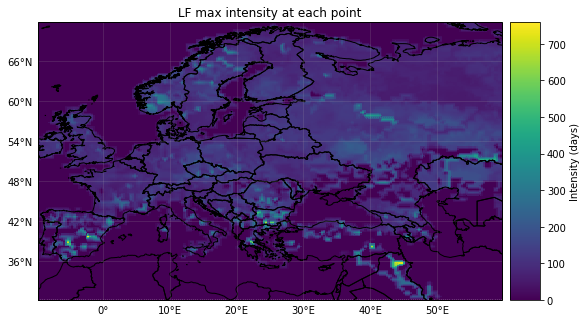

In [707]:
hazard.plot_intensity(0)

In [ ]:
index=11
exposuresn = exposures[historical_data['Energy'][index]]
country = historical_data['Country'][index].split(',')
exposuresn = exposuresn[exposuresn.country_long.isin(country)]
exposuresn = Exposures(exposuresn)
exposuresn.check()

#impact_function = init_IFS_linear(historical_data['slope_if'][index])
impact_function = init_IFS_linear(0.009)

hazardn = hazard.select(date=(historical_data['date0'][index].toordinal(),historical_data['daten'][index].toordinal()))
impact = Impact()
impact.calc(exposuresn, impact_function, hazardn)

In [682]:
historical_data

,Energy,Country,date0,daten,loss,unit,slope_lf
0,Hydro,Portugal,2005-01-01,2006-01-01,21.0,percentage,NA
1,Hydro,Spain,2005-01-01,2006-01-01,37.5,percentage,NA
2,Hydro,France,2005-01-01,2006-01-01,10000.0,Gwh,0.008
3,Hydro,Albania,2003-01-01,2004-01-01,33.0,percentage,NA
4,Hydro,Spain,2004-01-01,2008-01-01,17.0,percentage,NA
5,Hydro,"Finland, Sweden, Norway",2002-01-01,2003-01-01,7.8,percentage,0.003
6,Hydro,"Finland, Sweden, Norway",1996-01-01,1997-01-01,21.3,percentage,0.009
7,Hydro,Spain,1992-01-01,1994-01-01,14.5,percentage,NA
8,Hydro,India,2008-01-01,2010-01-01,8.0,percentage,NA
9,Nuclear,France,2003-01-01,2004-01-01,5500.0,Gwh,0.002


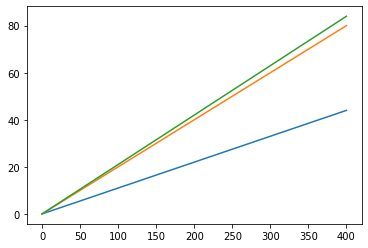

In [713]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
for index, row in historical_data[historical_data['Energy']=='Nuclear'].iterrows():
    ax.plot(x0,x0*historical_data['slope_if'][index]*100)

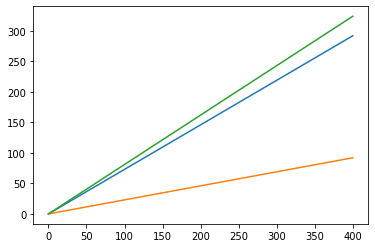

In [712]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
for index, row in historical_data[historical_data['Energy']=='Hydro'].iterrows():
    if historical_data['slope_if'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if'][index]*100)